# Preparación de datos
## Importar bibliotecas

In [3]:
import pandas as pd 
import numpy as np 
import scipy as sp
import math
import re
from tqdm import tqdm
import json
import gzip
from unidecode import unidecode
from pyspark.sql.functions import udf
import matplotlib.pyplot as plt

import seaborn as sns
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, IntegerType, BooleanType
from pyspark.sql.functions import from_json, col
from pyspark.sql.functions import explode


# Importar funciones necesarias
from pyspark.sql.functions import col, to_date, weekofyear,year,trim, month, dayofmonth, sum
from pyspark.sql.functions import col,  count, coalesce, sum as spark_sum
from pyspark.sql.functions import regexp_replace, col, when, explode_outer,lit, to_timestamp,regexp_extract,lower,split
from pyspark.sql.functions import format_number
from pyspark.sql.types import IntegerType,FloatType
# Puedes obtener estadísticas específicas para una columna
from pyspark.sql.functions import mean, min, max
from pyspark.sql.functions import approx_count_distinct
from pyspark.sql.window import Window
from pyspark.sql.functions import log1p
from pyspark.sql import functions as F

from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.types import *


## Inicio de Sessión Cluster

In [4]:

spark = SparkSession.builder.appName("MLops_Steam").getOrCreate()
#spark = SparkSession.builder.master("spark://localhost:7077").appName("MLops1").getOrCreate()


In [5]:
spark

## Importación de Datos `user_reviews.json.gz`

In [ ]:


def clean_text(text):
    # Reemplazar caracteres no ASCII con un espacio en blanco
    cleaned_text = ''.join(char if ord(char) < 128 else ' ' for char in text)
    return cleaned_text

def read_and_clean_reviews(file_path):
    cleaned_reviews = []
    with gzip.open(file_path, 'rt', encoding='utf-8') as file:
        for line in file:
            try:
                # Limpiar caracteres no ASCII
                cleaned_line = clean_text(line)
                
                # Convertir la línea limpiada a un diccionario
                review_dict = eval(cleaned_line)
                
                # Agregar el diccionario limpiado a la lista de revisiones
                cleaned_reviews.append(review_dict)
            except Exception as e:
                print(f"Error al procesar la línea: {line}")
                print(f"Error: {e}")
    
    return cleaned_reviews

# Ejemplo de uso
file_path = '../datasets/raw/user_reviews.json.gz'  # Reemplaza con la ruta real de tu archivo comprimido
reviews = read_and_clean_reviews(file_path)

# Crear una lista de tuplas con la información necesaria
data = []
for review in reviews:
    user_id = review['user_id']
    user_url = review['user_url']
    user_reviews = review.get('reviews', [])
    
    for user_review in user_reviews:
        item_id = user_review.get('item_id', '')
        recommend = user_review.get('recommend', False)
        review_text = user_review.get('review', '')
        funny = user_review.get('funny', '')
        posted = user_review.get('posted', '')
        last_edited = user_review.get('last_edited', '')
        helpful = user_review.get('helpful', '')

        data.append((user_id, user_url, item_id, recommend, review_text, funny, posted, last_edited, helpful))

# Crear el esquema del DataFrame
schema = StructType([
    StructField("user_id", StringType(), True),
    StructField("user_url", StringType(), True),
    StructField("item_id", StringType(), True),
    StructField("recommend", BooleanType(), True),
    StructField("review", StringType(), True),
    StructField("funny", StringType(), True),
    StructField("posted", StringType(), True),
    StructField("last_edited", StringType(), True),
    StructField("helpful", StringType(), True)
])

# Crear el DataFrame de PySpark
df = spark.createDataFrame(data, schema=schema)

# Mostrar el DataFrame
df.show(truncate=False)


In [ ]:
# Selecciona la columna que quieres contar
columna = "user_id"  # Reemplaza con el nombre real de tu columna
# Toma una muestra del 10% de las filas para esa columna
sampled_count = df.select(columna).sample(fraction=0.1, seed=42).agg(count("*")).collect()[0][0]
print((sampled_count, len(df.columns)))

### Taxonomía de Datos Analíticos `user_reviews.json.gz`
- Se estructuro a 60'380 Registos y 9 Variables
- Taxonomía original:

#### user_reviews.gz.json

| Variable   | Descripción                              | Ejemplo                                                                                                                                            |
|-----------|------------------------------------------|----------------------------------------------------------------------------------------------------------------------------------------------------|
| user_id   | Identificador único de usuario            | [76561197970982479, evcentric, maplemage]                                                                                                          |
| user_url  | URL del perfil del usuario                | [http://steamcommunity.com/id/evcentric]                                                                                                          |
| reviews   | Review de usuario en formato JSON         | {'funny': '', 'posted': 'Posted September 8, 2013.', 'last_edited': '', 'item_id': '227300', 'helpful': '0 of 1 people (0%) found this review helpful', 'recommend': True, 'review': "For a simple (it's actually not all that simple but it can be!) truck driving Simulator, it is quite a fun and relaxing game. Playing on simple (or easy?) its just the basic WASD keys for driving but (if you want) the game can be much harder and realistic with having to manually change gears, much harder turning, etc. And reversing in this game is a ♥♥♥♥♥, as I imagine it would be with an actual truck. Luckily, you don't have to reverse park it but you get extra points if you do cause it is bloody hard. But this is surprisingly a nice truck driving game and I had a bit of fun with it."} |


## Importación de Datos `users_items.json.gz`

In [ ]:

def clean_text(text):
    # Reemplazar caracteres no ASCII con un espacio en blanco
    cleaned_text = ''.join(char if ord(char) < 128 else ' ' for char in text)
    return cleaned_text

def read_and_clean_reviews(file_path):
    cleaned_reviews = []
    with gzip.open(file_path, 'rt', encoding='utf-8') as file:
        for line in file:
            try:
                # Limpiar caracteres no ASCII
                cleaned_line = clean_text(line)
                
                # Convertir la línea limpiada a un diccionario
                review_dict = eval(cleaned_line)
                
                # Agregar el diccionario limpiado a la lista de revisiones
                cleaned_reviews.append(review_dict)
            except Exception as e:
                print(f"Error al procesar la línea: {line}")
                print(f"Error: {e}")
    
    return cleaned_reviews

# Ejemplo de uso
file_path = '../datasets/raw/users_items.json.gz'  # Reemplaza con la ruta real de tu archivo comprimido
items = read_and_clean_reviews(file_path)

# Crear una lista de tuplas con la información necesaria
data = []
for item in items:
    user_id = item.get('user_id', '')
    items_count = item.get('items_count', '')
    steam_id = item.get('steam_id', '')
    user_url = item.get('user_url', '')
    user_items = item.get('items', [])
    
    for user_item in user_items:
        item_id = user_item.get('item_id', '')
        item_name = user_item.get('item_name', '')
        playtime_forever = user_item.get('playtime_forever', '')
        playtime_2weeks = user_item.get('playtime_2weeks', '')

        data.append((user_id, items_count, steam_id, user_url, item_id, item_name, playtime_forever, playtime_2weeks))

# Crear el esquema del DataFrame
schema = StructType([
    StructField("user_id", StringType(), True),
    StructField("items_count", StringType(), True),
    StructField("steam_id", StringType(), True),
    StructField("user_url", StringType(), True),
    StructField("item_id", StringType(), True),
    StructField("item_name", StringType(), True),
    StructField("playtime_forever", StringType(), True),
    StructField("playtime_2weeks", StringType(), True)
])

# Crear el DataFrame de PySpark
df2 = spark.createDataFrame(data, schema=schema)

# Mostrar el DataFrame
#df2.show(5, truncate=False)


In [ ]:
# Selecciona la columna que quieres contar
columna = "user_id"  # Reemplaza con el nombre real de tu columna

# Toma una muestra del 10% de las filas para esa columna
sampled_count = df.select(columna).sample(fraction=0.01, seed=42).agg(count("*")).collect()[0][0]

print((sampled_count, len(df.columns)))

### Taxonomía de Datos Analíticos `users_items.json.gz`
- Se estructuro a 63'200 Registos y 9 Variables
- Taxonomía original:


#### user_items.gz.json

| Columna | Descripción | Ejemplo |
|---------|-------------|---------|
| user_id | Identificador único de usuario | [76561197970982479, evcentric, maplemage] |
| user_url | URL del perfil del usuario | [http://steamcommunity.com/id/evcentric](http://steamcommunity.com/id/evcentric) |
| items | Items de usuario en formato Json | {'item_id': '273350', 'item_name': 'Evolve Stage 2', 'playtime_forever': 58, 'playtime_2weeks': 0} |


## Importación de Datos `steam_games.json.gz`

In [ ]:
def clean_text(text):
    # Reemplazar caracteres no ASCII con un espacio en blanco
    cleaned_text = ''.join(char if ord(char) < 128 else ' ' for char in text)
    return cleaned_text

def read_and_clean_reviews(file_path):
    cleaned_reviews = []
    with gzip.open(file_path, 'rt', encoding='utf-8') as file:
        for line in file:
            try:
                # Limpiar caracteres no ASCII
                cleaned_line = clean_text(line)
                
                # Convertir la línea limpiada a un diccionario
                review_dict = json.loads(cleaned_line)
                
                # Reemplazar NaN con cadena vacía
                review_dict = {k: '' if isinstance(v, float) and math.isnan(v) else v for k, v in review_dict.items()}
                
                # Agregar el diccionario limpiado a la lista de revisiones
                cleaned_reviews.append(review_dict)
            except Exception as e:
                print(f"Error al procesar la línea: {line}")
                print(f"Error: {e}")
    
    return cleaned_reviews


# Ruta al archivo comprimido
file_path = '../datasets/raw/steam_games.json.gz'  # Reemplaza con la ruta real de tu archivo comprimido
games = read_and_clean_reviews(file_path)

# Crear una lista de tuplas con la información necesaria
data = []
for game in games:
    publisher = game.get('publisher', '')
    app_name = game.get('app_name', '')
    title = game.get('title', '')
    url = game.get('url', '')
    release_date = game.get('release_date', '')
    tags = game.get('tags', [])
    reviews_url = game.get('reviews_url', '')
    specs = game.get('specs', [])
    price = game.get('price', '')
    early_access = game.get('early_access', '')
    game_id = game.get('id', '')
    developer = game.get('developer', '')
    genres = game.get('genres', [])
    
    # Convertir listas a cadenas separadas por comas
    tags_str = ', '.join(map(str, tags))
    specs_str = ', '.join(map(str, specs))
    genres_str = ', '.join(map(str, genres))

    data.append((publisher, app_name, title, url, release_date, tags_str, reviews_url, specs_str,
                 price, early_access, game_id, developer, genres_str))

# Crear el esquema del DataFrame
schema = StructType([
    StructField("publisher", StringType(), True),
    StructField("app_name", StringType(), True),
    StructField("title", StringType(), True),
    StructField("url", StringType(), True),
    StructField("release_date", StringType(), True),
    StructField("tags_str", StringType(), True),
    StructField("reviews_url", StringType(), True),
    StructField("specs_str", StringType(), True),
    StructField("price", StringType(), True),
    StructField("early_access", StringType(), True),
    StructField("game_id", StringType(), True),
    StructField("developer", StringType(), True),
    StructField("genres_str", StringType(), True),
])

# Crear el DataFrame de PySpark
df3 = spark.createDataFrame(data, schema=schema)

# Mostrar el DataFrame
df3.show(5, truncate=False)

# Detener la sesión de Spark
#spark.stop()

In [ ]:
# Selecciona la columna que quieres contar
columna = "publisher"  # Reemplaza con el nombre real de tu columna

# Toma una muestra del 10% de las filas para esa columna
sampled_count = df3.select(columna).sample(fraction=0.01, seed=42).agg(count("*")).collect()[0][0]

print((sampled_count, len(df3.columns)))

In [ ]:
df3.distinct().show(20, truncate=False)

### Taxonomía de Datos Analíticos `steam_games.json.gz`
- Se estructuro a 128'100 Registos y 13 Variables
- Se validó que la variable `metascore` no existe en el set de datos origen  
- Taxonomía original:

#### steam_games.gz.json

| Variable          | Descripción                                      | Ejemplo                                                                                                            |
|-------------------|--------------------------------------------------|--------------------------------------------------------------------------------------------------------------------|
| publisher         | Empresa publicadora del contenido               | [Ubisoft, Dovetail Games - Trains, Degica]                                                                         |
| genres            | Género del contenido                             | [Action, Adventure, Racing, Simulation, Strategy]                                                                   |
| app_name          | Nombre del contenido                             | [Warzone, Soundtrack, Puzzle Blocks]                                                                                |
| title             | Título del contenido                              | [The Dream Machine: Chapter 4, Fate/EXTELLA - Sweet Room Dream, Fate/EXTELLA - Charming Bunny]                       |
| url               | URL de publicación del contenido                | [http://store.steampowered.com/app/761140/Lost_Summoner_Kitty/]                                                    |
| release_date      | Fecha de lanzamiento                              | [2018-01-04]                                                                                                       |
| tags              | Etiquetas de contenido                           | [Simulation, Indie, Action, Adventure, Funny, Open World, First-Person, Sandbox, Free to Play]                      |
| discount_price    | Precio de descuento                               | [22.66, 0.49, 0.69]                                                                                                |
| reviews_url       | Reviews de contenido                              | [http://steamcommunity.com/app/681550/reviews/?browsefilter=mostrecent&p=1]                                        |
| specs             | Especificaciones                                 | [Multi-player, Co-op, Cross-Platform Multiplayer, Downloadable Content]                                            |
| price             | Precio del contenido                              | [4.99, 9.99, Free to Use, Free to Play]                                                                             |
| early_access      | Acceso temprano                                  | [False, True]                                                                                                      |
| id                | Identificador único de contenido                 | [761140, 643980, 670290]                                                                                           |
| developer         | Desarrollador                                    | [Kotoshiro, Secret Level SRL, Poolians.com]                                                                        |
| metascore         | Score por Metacritic                             | [80, 74, 77, 75]                                                                                                   |


## Exportación Modelo de Datos a Parquet

In [ ]:
# Guardar el DataFrame en formato Parquet
# Ruta de destino para el archivo Parquet
ruta_destino_parquet_i = '../datasets/raw/user_reviews_parquet'
df.write.mode("overwrite").parquet(ruta_destino_parquet_i)

In [ ]:
# Guardar el DataFrame en formato Parquet
# Ruta de destino para el archivo Parquet
ruta_destino_parquet_ii = '../datasets/raw/users_items_parquet'
df2.write.mode("overwrite").parquet(ruta_destino_parquet_ii)

In [ ]:
# Guardar el DataFrame en formato Parquet
# Ruta de destino para el archivo Parquet
ruta_destino_parquet_iii = '../datasets/raw/steam_games_parquet'
df3.write.mode("overwrite").parquet(ruta_destino_parquet_iii)

## Exploratorio de la información EDA 

- **Importación de Modelo de datos sin cambios**

In [7]:
# Leer el archivo Parquet
steam_games = spark.read.parquet("../datasets/raw/steam_games_parquet")
user_reviews = spark.read.parquet("../datasets/raw/user_reviews_parquet")
users_items = spark.read.parquet("../datasets/raw/users_items_parquet")

- **Renombrar a las columnas**

In [8]:
# Definir la función para limpiar y formatear los nombres de las columnas
def limpiar_nombres_columnas(df):
    # Función para limpiar y formatear un solo nombre de columna
    def limpiar_nombre(nombre):
        # Eliminar caracteres especiales y espacios
        nombre = re.sub(r'\W+', '_', nombre)
        # Eliminar acentos
        nombre = unidecode(nombre)
        # Convertir a minúsculas
        nombre = nombre.lower()
        return nombre
    
    # Aplicar la función a cada nombre de columna
    nuevos_nombres = [limpiar_nombre(col) for col in df.columns]
    
    # Renombrar las columnas en el DataFrame
    for viejo, nuevo in zip(df.columns, nuevos_nombres):
        df = df.withColumnRenamed(viejo, nuevo)
    
    return df

# Aplicar la función a cada DataFrame
steam_games = limpiar_nombres_columnas(steam_games)
user_reviews = limpiar_nombres_columnas(user_reviews)
users_items = limpiar_nombres_columnas(users_items)

- **Propuesta de Modelo de datos sin cambios**

In [9]:
print("Modelo de datos de: steam_games ")
print("Cantidad de registros :", steam_games.count(), "Cantidad de las Columnas :", len(steam_games.columns))
print("\n")
steam_games.printSchema()
print("\n")
steam_games.show(2)

Modelo de datos de: steam_games 


Cantidad de registros : 120445 Cantidad de las Columnas : 13


root
 |-- publisher: string (nullable = true)
 |-- app_name: string (nullable = true)
 |-- title: string (nullable = true)
 |-- url: string (nullable = true)
 |-- release_date: string (nullable = true)
 |-- tags_str: string (nullable = true)
 |-- reviews_url: string (nullable = true)
 |-- specs_str: string (nullable = true)
 |-- price: string (nullable = true)
 |-- early_access: string (nullable = true)
 |-- game_id: string (nullable = true)
 |-- developer: string (nullable = true)
 |-- genres_str: string (nullable = true)



+-------------------+--------------------+--------------------+--------------------+------------+--------------------+--------------------+--------------------+-----+------------+-------+-------------------+--------------------+
|          publisher|            app_name|               title|                 url|release_date|            tags_str|         reviews_url|           specs_str|price|early_acce

In [7]:
print("Modelo de datos de: user_reviews ")
print("Cantidad de registros:", user_reviews.count(), "Cantidad de las Columnas:", len(user_reviews.columns))
print("\n")
user_reviews.printSchema()
print("\n")
user_reviews.show(2, truncate=False)

Modelo de datos de: user_reviews 
Cantidad de registros: 59305 Cantidad de las Columnas: 9


root
 |-- user_id: string (nullable = true)
 |-- user_url: string (nullable = true)
 |-- item_id: string (nullable = true)
 |-- recommend: boolean (nullable = true)
 |-- review: string (nullable = true)
 |-- funny: string (nullable = true)
 |-- posted: string (nullable = true)
 |-- last_edited: string (nullable = true)
 |-- helpful: string (nullable = true)



+-------------------+------------------------------------------------+-------+---------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [8]:
print("Modelo de datos de: users_items ")
print("Cantidad de registros", users_items.count(), "Cantidad de las Columnas", len(users_items.columns))
print("\n")
users_items.printSchema()
print("\n")
users_items.show(2, truncate=False)

Modelo de datos de: users_items 
Cantidad de registros 5153209 Cantidad de las Columnas 8


root
 |-- user_id: string (nullable = true)
 |-- items_count: string (nullable = true)
 |-- steam_id: string (nullable = true)
 |-- user_url: string (nullable = true)
 |-- item_id: string (nullable = true)
 |-- item_name: string (nullable = true)
 |-- playtime_forever: string (nullable = true)
 |-- playtime_2weeks: string (nullable = true)



+-----------------+-----------+-----------------+----------------------------------------------------+-------+---------------------+----------------+---------------+
|user_id          |items_count|steam_id         |user_url                                            |item_id|item_name            |playtime_forever|playtime_2weeks|
+-----------------+-----------+-----------------+----------------------------------------------------+-------+---------------------+----------------+---------------+
|76561197971591953|11         |76561197971591953|http://steamcomm

## Preprocesamiento de Datos
- Nulos, vacios, carcteres en blanco y/o caracteres especiales.

In [10]:
# Define the function to count null or empty values for each column
def count_null_values(df):
    return df.select(
        *[sum(coalesce(col(c) == "", col(c).isNull()).cast("int")).alias(c) for c in df.columns]
    )

# Clean and count null values for each DataFrame
steam_games = limpiar_nombres_columnas(steam_games)
valores_vacios_por_columna_steam = count_null_values(steam_games)
valores_vacios_por_columna_steam.show()

user_reviews = limpiar_nombres_columnas(user_reviews)
valores_vacios_por_columna_reviews = count_null_values(user_reviews)
valores_vacios_por_columna_reviews.show()

users_items = limpiar_nombres_columnas(users_items)
valores_vacios_por_columna_items = count_null_values(users_items)
valores_vacios_por_columna_items.show()

+---------+--------+-----+-----+------------+--------+-----------+---------+-----+------------+-------+---------+----------+
|publisher|app_name|title|  url|release_date|tags_str|reviews_url|specs_str|price|early_access|game_id|developer|genres_str|
+---------+--------+-----+-----+------------+--------+-----------+---------+-----+------------+-------+---------+----------+
|    96362|   88312|90360|88310|       90377|   88473|      88312|    88980|89687|       88310|  88312|    91609|     91593|
+---------+--------+-----+-----+------------+--------+-----------+---------+-----+------------+-------+---------+----------+

+-------+--------+-------+---------+------+-----+------+-----------+-------+
|user_id|user_url|item_id|recommend|review|funny|posted|last_edited|helpful|
+-------+--------+-------+---------+------+-----+------+-----------+-------+
|      0|       0|      0|        0|    30|51154|     0|      53165|      0|
+-------+--------+-------+---------+------+-----+------+----------

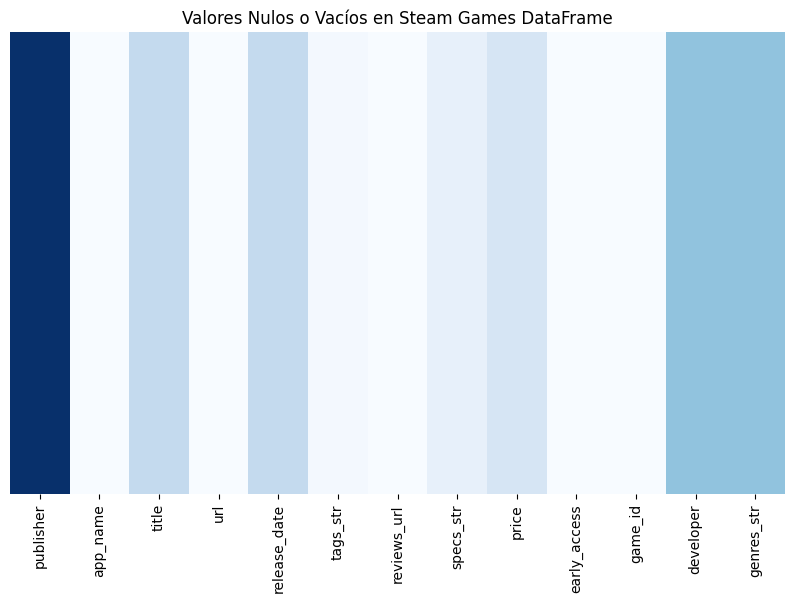

In [18]:
valores_vacios_por_columna_items = count_null_values(users_items)

# Visualize null or empty values in 'steam_games'
plt.figure(figsize=(10, 6))
sns.heatmap(valores_vacios_por_columna_steam.toPandas(), yticklabels=False, cbar=False, cmap="Blues")
plt.title('Valores Nulos o Vacíos en Steam Games DataFrame')
plt.show()


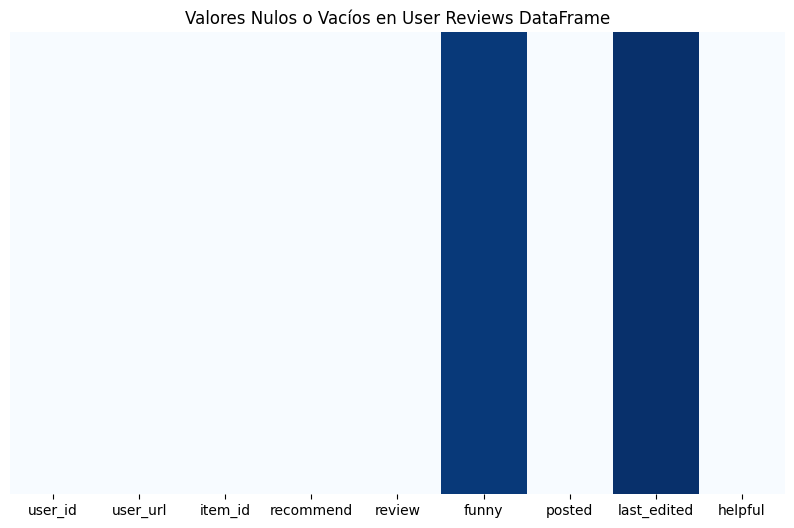

In [19]:

# Visualize null or empty values in 'user_reviews'
plt.figure(figsize=(10, 6))
sns.heatmap(valores_vacios_por_columna_reviews.toPandas(), yticklabels=False, cbar=False, cmap="Blues")
plt.title('Valores Nulos o Vacíos en User Reviews DataFrame')
plt.show()

- **Valores únicos Price `steam_games`**

In [106]:
# Get unique values in the "price" column as a list
unique_prices = steam_games.select("price").distinct().orderBy("price").collect()

# Display the unique values as an array
price_array = [row.price for row in unique_prices]
print(price_array)

['', '0.49', '0.5', '0.89', '0.95', '0.98', '0.99', '1.0', '1.25', '1.29', '1.39', '1.49', '1.5', '1.59', '1.87', '1.95', '1.99', '10.0', '10.49', '10.93', '10.96', '10.99', '109.99', '11.15', '11.99', '119.99', '12.0', '12.89', '12.99', '124.99', '129.99', '13.37', '13.98', '13.99', '131.4', '139.92', '14.95', '14.99', '149.99', '15.0', '15.99', '16.06', '16.99', '160.91', '17.99', '172.24', '179.0', '18.9', '18.99', '189.0', '189.96', '19.29', '19.95', '19.98', '19.99', '199.0', '199.99', '2.0', '2.3', '2.49', '2.66', '2.89', '2.97', '2.99', '20.0', '20.99', '202.76', '21.99', '22.99', '23.96', '23.99', '234.99', '24.99', '249.99', '26.99', '27.49', '27.99', '289.99', '29.96', '29.99', '299.99', '3.0', '3.33', '3.39', '3.49', '3.99', '30.0', '31.99', '32.99', '320.0', '34.99', '36.99', '38.85', '39.99', '399.0', '399.99', '4.0', '4.29', '4.49', '4.68', '4.99', '40.0', '41.99', '42.99', '44.98', '44.99', '49.0', '49.99', '499.99', '5.0', '5.49', '5.65', '5.99', '54.99', '59.95', '59.9

- **Estrategia de tratamiento de nulos, vacios, caracteres especiales Price `steam_games`**

In [22]:
steam_games = steam_games.withColumn(
    "price",
    when(steam_games["price"].isin("", "Free", "Free Demo", "Free HITMAN™ Holiday Pack", "Free Mod", "Free Movie", "Free To Play", "Free to Play", "Free to Try", "Free to Use", "Install Now", "Install Theme", "Play Now", "Play WARMACHINE: Tactics Demo", "Play for Free!", "Play the Demo", "Third-party"), -1.0)
    .otherwise(regexp_extract(steam_games["price"], r'\d+(\.\d+)?', 0).cast("float"))
)

# Tratar los valores en la columna 'release_date'
steam_games_transformed = steam_games.withColumn(
    "release_date",
    when(
        (steam_games["release_date"] == "") | 
        (steam_games["release_date"] == '"""Soon"""') | 
        (steam_games["release_date"].rlike('[^\d-]')), 
        '1970-01-01'
    )
    .otherwise(steam_games["release_date"])
)

# Extraer los años de la columna 'release_date' y crear la columna 'year'
steam_games_transformed = steam_games_transformed.withColumn(
    "year",
    when(
        (steam_games_transformed["release_date"] != "") & (steam_games_transformed["release_date"].rlike(r"(\d{4})")),
        regexp_extract(steam_games_transformed["release_date"], r"(\d{4})", 1).cast(IntegerType())
    )
    .otherwise(
        when(
            (steam_games_transformed["release_date"].like("%soon%") | steam_games_transformed["release_date"].like("%Soon%")),
            "TBD"
        )
        .otherwise("Unknown")
    )
)

# Tratar los valores en la columna 'early_access'
steam_games_transformed = steam_games_transformed.withColumn(
    "early_access",
    when(steam_games_transformed["early_access"] == "", -1)
    .when(steam_games_transformed["early_access"] == "false", 0)
    .when(steam_games_transformed["early_access"] == "true", 1)
    .otherwise("Unknown")
)
# Convertir la columna 'year' a tipo entero
steam_games_transformed = steam_games_transformed.withColumn("year", when(steam_games_transformed["year"] != "TBD", steam_games_transformed["year"].cast(IntegerType())).otherwise(-1))
# 1. Usa explode para convertir la lista en filas adicionales
df_exploded = steam_games_transformed.select("genres_str", explode(split("genres_str", ",")).alias("genre"))

# 2. Puedes realizar más transformaciones si es necesario
# Por ejemplo, si quieres agregar alguna lógica específica o limpieza de datos
# Puedes realizar operaciones como trim, regexp_replace, etc.
df_exploded = df_exploded.withColumn("genre", lower(regexp_replace(trim(col("genre")), "[^a-zA-Z0-9_]", "")))

# 3. Reemplazar cadenas vacías en la columna 'genre' por 'Unknown'
df_exploded = df_exploded.withColumn("genre", when(col("genre") == "", "Unknown").otherwise(col("genre")))

# 4. Actualizar los valores en la tabla steam_games_transformed
steam_games_transformed = steam_games_transformed.join(df_exploded, on="genres_str")
steam_games_transformed = steam_games_transformed.withColumn("genres_str", col("genre")).drop("genre")

In [24]:
steam_games_transformed.show(5)

+----------+------------------+--------------+--------------+--------------------+------------+--------------------+--------------------+--------------------+-----------------+------------+-------+----------+----+
|genres_str|         publisher|      app_name|         title|                 url|release_date|            tags_str|         reviews_url|           specs_str|            price|early_access|game_id| developer|year|
+----------+------------------+--------------+--------------+--------------------+------------+--------------------+--------------------+--------------------+-----------------+------------+-------+----------+----+
|     indie|Neko Entertainment|Wooden Sen'SeY|Wooden Sen'SeY|http://store.stea...|  2013-12-05|Action, Indie, Pl...|http://steamcommu...|Single-player, St...|9.989999771118164|           0| 259830|Upper Byte|2013|
|    action|Neko Entertainment|Wooden Sen'SeY|Wooden Sen'SeY|http://store.stea...|  2013-12-05|Action, Indie, Pl...|http://steamcommu...|Single-

In [25]:
steam_games_transformed.printSchema()

root
 |-- genres_str: string (nullable = false)
 |-- publisher: string (nullable = true)
 |-- app_name: string (nullable = true)
 |-- title: string (nullable = true)
 |-- url: string (nullable = true)
 |-- release_date: string (nullable = true)
 |-- tags_str: string (nullable = true)
 |-- reviews_url: string (nullable = true)
 |-- specs_str: string (nullable = true)
 |-- price: double (nullable = true)
 |-- early_access: string (nullable = false)
 |-- game_id: string (nullable = true)
 |-- developer: string (nullable = true)
 |-- year: integer (nullable = true)



In [9]:
# Obtener valores únicos de la columna 'early_access' como lista
unique_access_values = steam_games_transformed.select("genres_str").distinct().orderBy("genres_str")
# Convertir a lista
access_list = [row.genres_str for row in unique_access_values.collect()]
# Mostrar los valores únicos como un array
print(access_list)

['Unknown', 'accounting', 'action', 'adventure', 'animationampmodeling', 'audioproduction', 'casual', 'designampillustration', 'earlyaccess', 'education', 'freetoplay', 'indie', 'massivelymultiplayer', 'photoediting', 'racing', 'rpg', 'simulation', 'softwaretraining', 'sports', 'strategy', 'utilities', 'videoproduction', 'webpublishing']


In [219]:
print("Cantidad de registros :", steam_games_transformed.count(), "Cantidad de las Columnas :", len(steam_games_transformed.columns))

Cantidad de registros : 8424842713 Cantidad de las Columnas : 15


In [242]:
steam_games_transformed.show(5)

+----------+------------------+--------------+--------------+--------------------+------------+--------------------+--------------------+--------------------+-----------------+------------+-------+----------+----+
|genres_str|         publisher|      app_name|         title|                 url|release_date|            tags_str|         reviews_url|           specs_str|            price|early_access|game_id| developer|year|
+----------+------------------+--------------+--------------+--------------------+------------+--------------------+--------------------+--------------------+-----------------+------------+-------+----------+----+
|     indie|Neko Entertainment|Wooden Sen'SeY|Wooden Sen'SeY|http://store.stea...|  2013-12-05|Action, Indie, Pl...|http://steamcommu...|Single-player, St...|9.989999771118164|           0| 259830|Upper Byte|2013|
|    action|Neko Entertainment|Wooden Sen'SeY|Wooden Sen'SeY|http://store.stea...|  2013-12-05|Action, Indie, Pl...|http://steamcommu...|Single-

In [229]:
# Obtener valores únicos de la columna 'early_access' como lista
unique_access_values = steam_games_transformed.select("developer").distinct().orderBy("developer")
# Convertir a lista
access_list = [row.developer for row in unique_access_values.collect()]
# Mostrar los valores únicos como un array
print(access_list)

['', '+7 Software', '+Mpact Games, LLC.', '.M.Y.W.', '.ez Games', '07th Expansion', '08 Games', '100 Plus Games llc', '100 Stones Interactive', '10101 Software', '10ft Games', '10kbit Games', '10ravens s.r.o.', '10th Art Studio,Adventure Productions', '10tons Ltd', '10x10 Room', '11 bit studios', '12 East Games', '12 Hit Combo', '1337 &amp; Senri AB', '13AM Games', '14 Dimension Enterprise', '14 Hours Productions', '14Dimension Enterprise', '14° East', '16 Swans', '16bit Nights', '17-BIT', '17Studio', '1888 Games', '1C Company', '1C Game Studios,777 Studios', '1C Wireless', '1C-Avalon', '1C-SoftClub', '1C: Maddox Games', '1C:InoCo', '1CC Games', '2 Monkeys', '2 Zombie Games', '2 players', '2-Volt Games', '2015', '2020 Venture', '20letpast', '22cans', '24 Caret Games', '251 Games', '26k', '29Palms Scenery Design', '29Palms,JaraNet', '2Awesome Studio', '2B_GAMES', '2Beats', '2Bit Studios', '2Chance Projects,IIchan Eroge Team', '2Chance Projects,IIchan Eroge Team,DjSM', '2D BOY', '2D Hero

#### Tratamiento `user_reviews` 

In [143]:
# Obtener valores únicos de la columna 'early_access' como lista
unique_access_values = user_reviews.select("recommend").distinct().orderBy("recommend")
# Convertir a lista
access_list = [row.recommend for row in unique_access_values.collect()]
# Mostrar los valores únicos como un array
print(access_list)

[False, True]


In [10]:
# Función para tratar la columna 'recommend'
def transform_recommend_column(df):
    df_transformed = df.withColumn(
        "recommend",
        when(df["recommend"] == True, 1)
        .otherwise(when(df["recommend"] == False, 0))
    ).withColumn("recommend", col("recommend").cast(IntegerType()))  # Convertir a tipo entero
    return df_transformed

In [11]:
# Aplicar la función al DataFrame de User Reviews
user_reviews_transformed = transform_recommend_column(user_reviews)

# Mostrar el DataFrame resultante
user_reviews_transformed.show(truncate=False)

+-------------------+----------------------------------------------------+-------+---------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [12]:
# Obtener valores únicos de la columna 'posted'
unique_posted_values = user_reviews_transformed.select("posted").distinct().orderBy("posted")
# Convertir a lista
posted_list = [row.posted for row in unique_posted_values.collect()]
# Mostrar los valores únicos como un array
print(posted_list)


['Posted April 1, 2012.', 'Posted April 1, 2013.', 'Posted April 1, 2014.', 'Posted April 1, 2015.', 'Posted April 1.', 'Posted April 10, 2012.', 'Posted April 10, 2013.', 'Posted April 10, 2014.', 'Posted April 10, 2015.', 'Posted April 10.', 'Posted April 11, 2012.', 'Posted April 11, 2013.', 'Posted April 11, 2014.', 'Posted April 11, 2015.', 'Posted April 11.', 'Posted April 12, 2012.', 'Posted April 12, 2013.', 'Posted April 12, 2014.', 'Posted April 12, 2015.', 'Posted April 12.', 'Posted April 13, 2012.', 'Posted April 13, 2013.', 'Posted April 13, 2014.', 'Posted April 13, 2015.', 'Posted April 13.', 'Posted April 14, 2012.', 'Posted April 14, 2013.', 'Posted April 14, 2014.', 'Posted April 14, 2015.', 'Posted April 14.', 'Posted April 15, 2011.', 'Posted April 15, 2012.', 'Posted April 15, 2013.', 'Posted April 15, 2014.', 'Posted April 15, 2015.', 'Posted April 15.', 'Posted April 16, 2012.', 'Posted April 16, 2013.', 'Posted April 16, 2014.', 'Posted April 16, 2015.', 'Poste

In [13]:
# Configura la propiedad para el analizador de fecha
spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")

In [14]:
from pyspark.sql.functions import regexp_replace, to_date, trim, when, expr, concat, lit, col
from pyspark.sql.types import StringType, DateType
from datetime import datetime

# Obtén el año actual
current_year = datetime.now().year

# Define el formato de fecha que parece tener el campo 'posted'
date_format = 'MMM d, yyyy.'

# Limpia y estandariza el campo 'posted' utilizando expresiones regulares
user_reviews_transformed = user_reviews_transformed.withColumn(
    "clean_posted",
    regexp_replace("posted", r'Posted\s*', '')  # Elimina 'Posted'
)

# Elimina espacios en blanco adicionales
user_reviews_transformed = user_reviews_transformed.withColumn(
    "clean_posted",
    trim(user_reviews_transformed["clean_posted"]).alias("clean_posted")
)

# Agrega el año actual a las fechas que no tienen año
user_reviews_transformed = user_reviews_transformed.withColumn(
    "clean_posted",
    when(user_reviews_transformed["clean_posted"].contains(","), user_reviews_transformed["clean_posted"]).otherwise(expr('concat(clean_posted, ", {}")'.format(current_year)))
)

# Elimina el punto intermedio y agrega un punto al final
user_reviews_transformed = user_reviews_transformed.withColumn(
    "clean_date",
    trim(concat(regexp_replace("clean_posted", r'\.,', ','), lit('.')))
)

# Convierte el campo 'clean_date' a formato de fecha utilizando to_date
user_reviews_transformed = user_reviews_transformed.withColumn(
    "posted_date",
    to_date("clean_date", date_format).cast(DateType()).alias("posted_date")
)

# Reemplaza las cadenas nulas o vacías en la columna 'review' con 'Unknown'
user_reviews_transformed = user_reviews_transformed.withColumn("review", when((col("review").isNull()) | (col("review") == ""), "Unknown").otherwise(col("review")))

# Muestra el DataFrame resultante
user_reviews_transformed.show(truncate=False)

+-------------------+----------------------------------------------------+-------+---------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [16]:
# Obtener valores únicos de la columna 'posted'
unique_posted_values = users_items.select("playtime_forever").distinct().orderBy("playtime_forever")
# Convertir a lista
posted_list = [row.playtime_forever for row in unique_posted_values.collect()]
# Mostrar los valores únicos como un array
print(posted_list)

['0', '1', '10', '100', '1000', '10000', '100004', '10001', '10002', '10003', '10004', '100040', '100048', '10005', '100051', '10006', '100067', '100069', '10007', '100078', '10008', '100085', '10009', '100098', '1001', '10010', '100101', '100102', '10011', '100116', '10012', '100124', '10013', '10014', '100144', '100147', '10015', '100157', '10016', '100164', '10017', '100178', '10018', '10019', '100196', '1002', '10020', '100205', '10021', '10022', '100222', '10023', '100231', '100232', '100236', '10024', '100243', '10025', '10026', '100262', '100269', '10027', '100270', '10028', '10029', '100296', '1003', '10030', '100301', '10031', '100310', '100316', '10032', '100325', '100328', '10033', '100330', '10034', '100344', '100345', '10035', '100353', '10036', '10037', '100370', '10038', '100385', '10039', '100391', '1004', '10040', '100402', '10041', '100413', '10042', '10043', '10044', '100441', '100445', '100446', '100449', '10045', '10046', '10047', '100470', '100478', '10048', '1004

In [17]:
# Obtener valores únicos de la columna 'posted'
unique_posted_values = users_items.select("playtime_2weeks").distinct().orderBy("playtime_2weeks")
# Convertir a lista
posted_list = [row.playtime_2weeks for row in unique_posted_values.collect()]
# Mostrar los valores únicos como un array
print(posted_list)

['0', '1', '10', '100', '1000', '1001', '1002', '10022', '10026', '1003', '1004', '1005', '10050', '1006', '1007', '10078', '10079', '1008', '1009', '101', '1010', '1011', '1012', '1013', '1014', '1015', '1016', '1017', '10172', '1018', '1019', '102', '1020', '1021', '1022', '1023', '1024', '1025', '1026', '1027', '1028', '10282', '10284', '1029', '103', '1030', '10307', '1031', '1032', '1033', '10333', '1034', '1035', '10358', '1036', '1037', '1038', '1039', '104', '1040', '1041', '1042', '1043', '10431', '1044', '1045', '1046', '1047', '1048', '1049', '105', '1050', '10503', '1051', '1052', '1053', '10535', '10537', '1054', '10543', '1055', '1056', '1057', '1058', '10589', '1059', '106', '1060', '1061', '1062', '1063', '1064', '1065', '10652', '10659', '1066', '1067', '1068', '1069', '107', '1070', '10700', '1071', '1072', '1073', '1074', '1075', '1076', '10767', '1077', '10779', '1078', '1079', '108', '1080', '1081', '1082', '1083', '1084', '1085', '10857', '1086', '10868', '1087', 

In [21]:
# Convierte la columna 'items_count' a entero
users_items_transformed = users_items.withColumn("items_count", col("items_count").cast("int"))

# Convierte la columna 'playtime_forever' a entero
users_items_transformed = users_items_transformed.withColumn("playtime_forever", col("playtime_forever").cast("int"))

# Convierte la columna 'playtime_2weeks' a entero
users_items_transformed = users_items_transformed.withColumn("playtime_2weeks", col("playtime_2weeks").cast("int"))

In [22]:
users_items_transformed.printSchema()

root
 |-- user_id: string (nullable = true)
 |-- items_count: integer (nullable = true)
 |-- steam_id: string (nullable = true)
 |-- user_url: string (nullable = true)
 |-- item_id: string (nullable = true)
 |-- item_name: string (nullable = true)
 |-- playtime_forever: integer (nullable = true)
 |-- playtime_2weeks: integer (nullable = true)



In [23]:
user_reviews_transformed.printSchema()

root
 |-- user_id: string (nullable = true)
 |-- user_url: string (nullable = true)
 |-- item_id: string (nullable = true)
 |-- recommend: integer (nullable = true)
 |-- review: string (nullable = true)
 |-- funny: string (nullable = true)
 |-- posted: string (nullable = true)
 |-- last_edited: string (nullable = true)
 |-- helpful: string (nullable = true)
 |-- clean_posted: string (nullable = true)
 |-- clean_date: string (nullable = true)
 |-- posted_date: date (nullable = true)



### Estadística descriptiva 

In [26]:
# Obtener solo las columnas numéricas
numeric_columns = [col_name for col_name, col_type in users_items_transformed.dtypes if col_type in ['int', 'bigint', 'double', 'float']]
# Estadísticas descriptivas de las columnas numéricas

# Calcular estadísticas descriptivas solo para las columnas numéricas
users_items_transformed.select(numeric_columns).describe().show()

+-------+-----------------+-----------------+-----------------+
|summary|      items_count| playtime_forever|  playtime_2weeks|
+-------+-----------------+-----------------+-----------------+
|  count|          5153209|          5153209|          5153209|
|   mean|314.7229326425534|991.4951407947941| 9.10470698937303|
| stddev|693.3596069542548|5418.204404857259|140.3925984740366|
|    min|                1|                0|                0|
|    max|             7762|           642773|            19967|
+-------+-----------------+-----------------+-----------------+



In [27]:
# Obtener solo las columnas numéricas
numeric_columns = [col_name for col_name, col_type in user_reviews_transformed.dtypes if col_type in ['int', 'bigint', 'double', 'float']]
# Estadísticas descriptivas de las columnas numéricas

# Calcular estadísticas descriptivas solo para las columnas numéricas
user_reviews_transformed.select(numeric_columns).describe().show()

+-------+------------------+
|summary|         recommend|
+-------+------------------+
|  count|             59305|
|   mean|0.8847989208329821|
| stddev|0.3192671440867632|
|    min|                 0|
|    max|                 1|
+-------+------------------+



In [28]:
# Obtener solo las columnas numéricas
numeric_columns = [col_name for col_name, col_type in steam_games_transformed.dtypes if col_type in ['int', 'bigint', 'double', 'float']]
# Estadísticas descriptivas de las columnas numéricas

# Calcular estadísticas descriptivas solo para las columnas numéricas
steam_games_transformed.select(numeric_columns).describe().show()

+-------+-------------------+
|summary|              price|
+-------+-------------------+
|  count|         8424842713|
|   mean|-0.6651402127718394|
| stddev|  4.006209254964431|
|    min|               -1.0|
|    max|              995.0|
+-------+-------------------+

